In [2]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
shot_metrics_df = pd.read_csv("shot_metric_df.csv")
shot_metrics_df.head()

,Unnamed: 0,event_id,event_index,period,timestamp,minute,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,location_x,location_y,location_z,related_events,player_id,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,gameId,match_date,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,birth_date
0,0,24392d1d-314a-4063-a729-7775bc0a2c45,130.0,1.0,00:03:04.524,3.0,4.0,9.0,0.471596,0.306241,0.278243,0.027997,0.007197,0.007197,0.0,0.027997,True,16.0,Shot,36.0,Manchester City,2.0,From Corner,36.0,Manchester City,112.7,39.9,0.22,"67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...",23616.0,Erling Håland,23.0,Center Forward,0.166126,1.0,0.0,Left Foot,1.0,3892755,2023-08-11,1.200000,0.0,0.0,1.000000,0.0,0.0,0.200000,0.0,0.0,0.400000,0.0,0.0,6.800000,0.0,0.0,4.400000,0.0,0.0,0.200000,0.0,0.0,17.017352,0.000000,0.000000,15.196193,0.000000,0.000000,20.433466,0.000000,0.000000,5.187833,0.000000,0.000000,37.352316,0.000000,0.000000,1.821159,0.000000,0.000000,306.501986,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-21
1,1,3c527d7b-6932-4190-8424-d1d3dcdd6a4d,191.0,1.0,00:05:11.529,5.0,11.0,11.0,1.023995,0.000000,0.034124,-0.034124,0.009421,0.009421,0.0,-0.034124,NaN,16.0,Shot,36.0,Manchester City,7.0,From Goal Kick,36.0,Manchester City,88.4,46.0,0.00,207b5c5a-ff48-4534-a5e2-0f83b20df80a,3089.0,Kevin De Bruyne,13.0,Right Center Midfield,0.023693,0.0,0.0,Right Foot,2.0,3892755,2023-08-11,4.000000,0.0,0.0,3.666667,0.0,0.0,0.666667,0.0,0.0,1.000000,0.0,0.0,14.000000,0.0,0.0,11.000000,0.0,0.0,0.333333,0.0,0.0,37.031555,0.000000,0.000000,31.198649,0.000000,0.000000,40.1

In [4]:
shot_metrics_df["age"]= (pd.to_datetime(shot_metrics_df["match_date"])-pd.to_datetime(shot_metrics_df["birth_date"]))/pd.Timedelta(days=365.25)
shot_metrics_df["age"]= shot_metrics_df["age"].astype(int)

<Axes: ylabel='Density'>

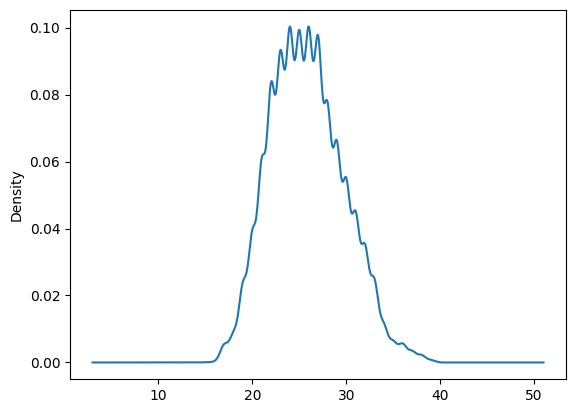

In [5]:
shot_metrics_df["age"].plot.density()

In [6]:

variable_list = [
    "High Intensity (HI) Distance_now", "High Intensity (HI) Distance_half", "High Intensity (HI) Distance_game", 
    "High Speed Running (HSR) Distance_now", "High Speed Running (HSR) Distance_half", "High Speed Running (HSR) Distance_game", 
    "Running Distance_now", "Running Distance_half", "Running Distance_game", 
    "Sprinting Distance_now", "Sprinting Distance_half", "Sprinting Distance_game", 
    "Total Distance_now", "Total Distance_half", "Total Distance_game", 
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]


In [7]:
#clean df for ML use
shot_metrics_df =shot_metrics_df[shot_metrics_df.penalty==0]
shot_metrics_df = shot_metrics_df.fillna(0)
shot_metrics_df.under_pressure = np.where(shot_metrics_df.under_pressure==True,1,0)


In [8]:
#leave spanish clubs out
#clubs to leave out of training

test_clubs = [
    "Athletic Club",
    "Getafe",
    "Real Betis",
    "Girona",
  "Las Palmas",
    "Sevilla",
    "Celta Vigo",
   "Deportivo Alavés",
     "Osasuna",
     "Barcelona",
    "Valencia",
     "Rayo Vallecano",
    "Real Sociedad",
     "Real Madrid",
     "Mallorca",
    "Villarreal",
    "Atlético Madrid"
    ]

In [9]:
shot_metrics_df.head(1)

,Unnamed: 0,event_id,event_index,period,timestamp,minute,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,location_x,location_y,location_z,related_events,player_id,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,gameId,match_date,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,birth_date,age
0,0,24392d1d-314a-4063-a729-7775bc0a2c45,130.0,1.0,00:03:04.524,3.0,4.0,9.0,0.471596,0.306241,0.278243,0.027997,0.007197,0.007197,0.0,0.027997,1,16.0,Shot,36.0,Manchester City,2.0,From Corner,36.0,Manchester City,112.7,39.9,0.22,"67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...",23616.0,Erling Håland,23.0,Center Forward,0.166126,1.0,0.0,Left Foot,1.0,3892755,2023-08-11,1.2,0.0,0.0,1.0,0.0,0.0,0.2,0.0,0.0,0.4,0.0,0.0,6.8,0.0,0.0,4.4,0.0,0.0,0.2,0.0,0.0,17.017352,0.0,0.0,15.196193,0.0,0.0,20.433466,0.0,0.0,5.187833,0.0,0.0,37.352316,0.0,0.0,1.821159,0.0,0.0,306.501986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000-07-21,23


In [10]:
ML_data= shot_metrics_df[["team_name","goal", "position_name","under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle"]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
position_name_onehot = pd.get_dummies(ML_data.position_name, 
    prefix="position_name")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,position_name_onehot], axis=1).drop(["play_pattern_name","body_part","position_name"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [11]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [12]:

# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",#logitraw
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.763


In [13]:
statsbomb_test = np.where(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg>0.5,1,0)
statsbomb_actual = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].goal)
statsbomb_proba = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8175,   86],
       [ 800,  130]])

In [15]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

In [16]:
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.904
ROC AUC: 0.763


In [17]:
acc = accuracy_score(statsbomb_actual,statsbomb_test )
roc = roc_auc_score(statsbomb_actual, statsbomb_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.908
ROC AUC: 0.793


In [18]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield', 'position_name_Center Back',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Goalkeeper',
       'position_name_Left Attacking Midfield', 'position_name_Left Back',
       'position_name_Left Center Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'pos

from autogluon.tabular import TabularPredictor
import numpy as np

# Compute class weights
neg, pos = np.bincount(y_train)
scale = neg / pos

# Assign weights: higher weight for goals (minority class)
weights = np.where(y_train == 1, scale, 1.0)

# Add weights column to training data
train_with_weights = X_train.copy()
#train_with_weights["weight"] = weights

# Fit AutoGluon with weights
predictor = TabularPredictor(
    label="goal",
    eval_metric="roc_auc",#""       # better than accuracy for imbalanced classes
    problem_type="binary"
).fit(
    training_data,
    #sample_weight="weight",
    presets="best_quality",
    time_limit=900
)

autogluon roc_auc 15 minutes
Accuracy: 0.906
ROC AUC: 0.777

from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming predictor is already trained:
# predictor = TabularPredictor(...).fit(...)

# Get predictions (hard labels) and predicted probabilities
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)[1]  # probability for class=1

# True labels
y_true = test_data["goal"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# ROC AUC
roc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


# Assuming you already trained:
# predictor = TabularPredictor(...).fit(...)

import matplotlib.pyplot as plt

fi = predictor.feature_importance(test_data)  # or training_data

# fi is a DataFrame with importance values
print(fi.head())

# Plot feature importance
fi.plot(kind="barh", figsize=(8, 10))
plt.title("Feature Importance")
plt.show()


In [19]:
importance = model.get_booster().get_score(importance_type="weight")
print(importance)

{'f0': 644.0, 'f1': 6338.0, 'f2': 6442.0, 'f3': 3071.0, 'f4': 1491.0, 'f5': 379.0, 'f6': 216.0, 'f7': 378.0, 'f8': 188.0, 'f9': 132.0, 'f10': 80.0, 'f11': 451.0, 'f12': 47.0, 'f13': 471.0, 'f14': 111.0, 'f15': 507.0, 'f16': 43.0, 'f17': 299.0, 'f18': 198.0, 'f19': 89.0, 'f20': 141.0, 'f21': 336.0, 'f23': 101.0, 'f24': 105.0, 'f25': 162.0, 'f26': 207.0, 'f27': 158.0, 'f28': 139.0, 'f29': 124.0, 'f30': 215.0, 'f31': 119.0, 'f32': 132.0, 'f33': 119.0, 'f34': 161.0, 'f35': 177.0, 'f36': 111.0, 'f37': 158.0, 'f38': 112.0, 'f39': 258.0, 'f40': 137.0}


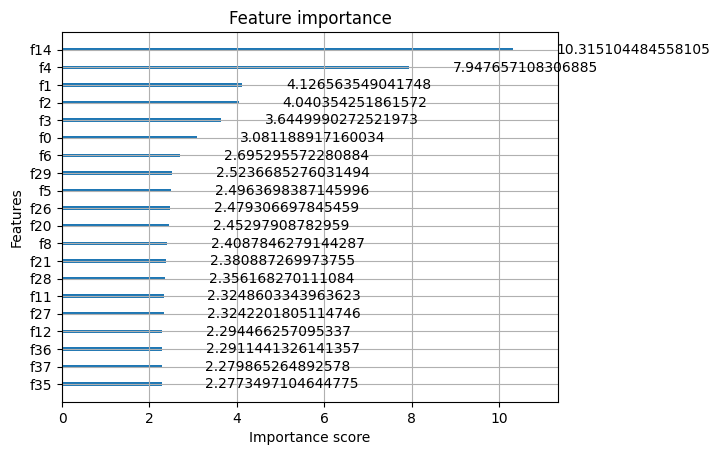

In [20]:
xgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

In [21]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield', 'position_name_Center Back',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Goalkeeper',
       'position_name_Left Attacking Midfield', 'position_name_Left Back',
       'position_name_Left Center Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'pos

In [22]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(10))

     importance
f14   10.315104
f4     7.947657
f1     4.126564
f2     4.040354
f3     3.644999
f0     3.081189
f6     2.695296
f29    2.523669
f5     2.496370
f26    2.479307


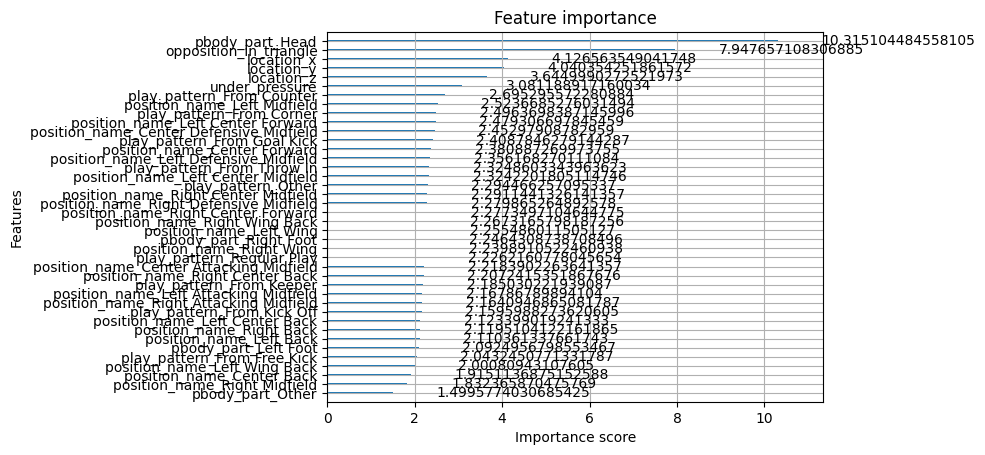

In [23]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()


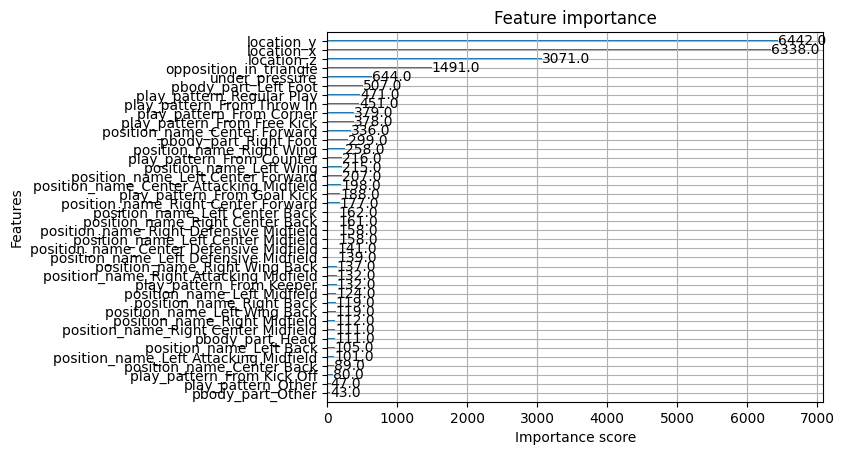

In [24]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="weight")
plt.show()


add physical metrics

In [25]:
def workload_index(df, period):
    return (
        df[f"Total Distance_{period}"] +
        2 * df[f"High Speed Running (HSR) Distance_{period}"] +
        3 * df[f"Sprinting Distance_{period}"] 
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    shot_metrics_df[f"WI_{period}"] = workload_index(shot_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
shot_metrics_df["ACWR"] = shot_metrics_df["WI_1_week"] / shot_metrics_df["WI_1_month"]
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"].isna(), 0,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"]>0.9, shot_metrics_df["ACWR"]*0.8,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR_bucket"] = pd.cut(
    shot_metrics_df["ACWR"],
    bins=4, 
    labels=["Q1 (lowest)", "Q2", "Q3","Q4"]
)
shot_metrics_df["ACWR_pos"] = np.where(shot_metrics_df["ACWR"]>0, 1,0)

In [26]:
len(shot_metrics_df[shot_metrics_df["ACWR"]==0])

24642

In [27]:
for thing in shot_metrics_df["ACWR_bucket"].unique():
    print(shot_metrics_df[shot_metrics_df["ACWR_bucket"]==thing].ACWR.max())

0.22459832468660804
0.8984126442491838
0.6735082919121836
0.44919372856540885


<Axes: ylabel='Density'>

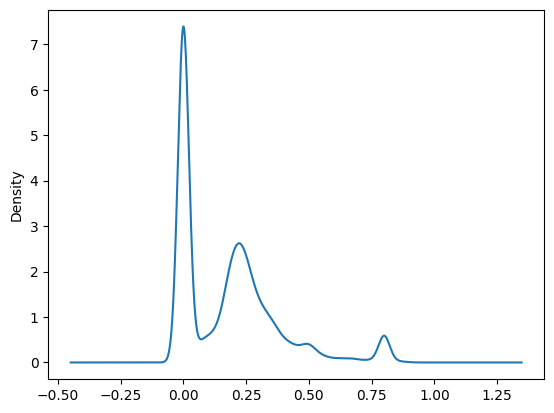

In [28]:
shot_metrics_df["ACWR"].plot.density()

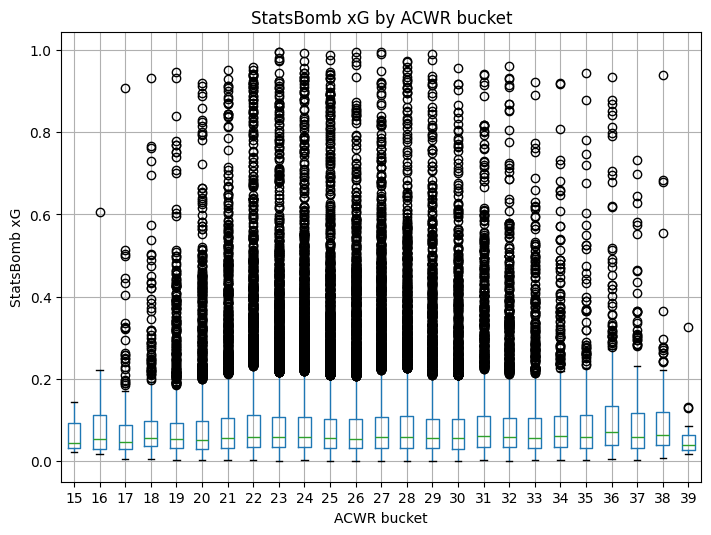

In [29]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="age", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

In [30]:
ML_data= shot_metrics_df[[
    "age","team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle",
    'WI_now', 'WI_game', 'WI_1_week','WI_2_week','WI_1_month',
       'ACWR','ACWR_bucket',
        'ACWR_pos'
    #"position_name",
    #"Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    #"Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    #"High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    #"Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    #"Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    #"Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    #"High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    #"Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    #"Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    #"Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    #"High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    #"Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
#position_name_onehot = pd.get_dummies(ML_data.position_name, 
#    prefix="position_name")#, dtype=float)
acwr_onehot = pd.get_dummies(ML_data.ACWR_bucket, 
    prefix="acwr")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,acwr_onehot ], axis=1).drop(["play_pattern_name","body_part",'ACWR_bucket'],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

just players with over 100 shots?

<Axes: ylabel='Density'>

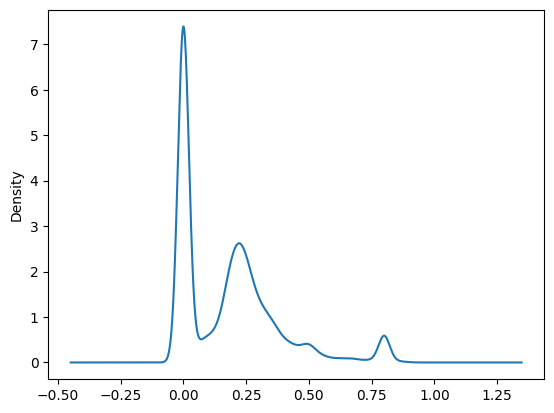

In [31]:
ML_data.ACWR.plot.density()

In [32]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [33]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.902
ROC AUC: 0.759


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8162,   99],
       [ 799,  131]])

In [35]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

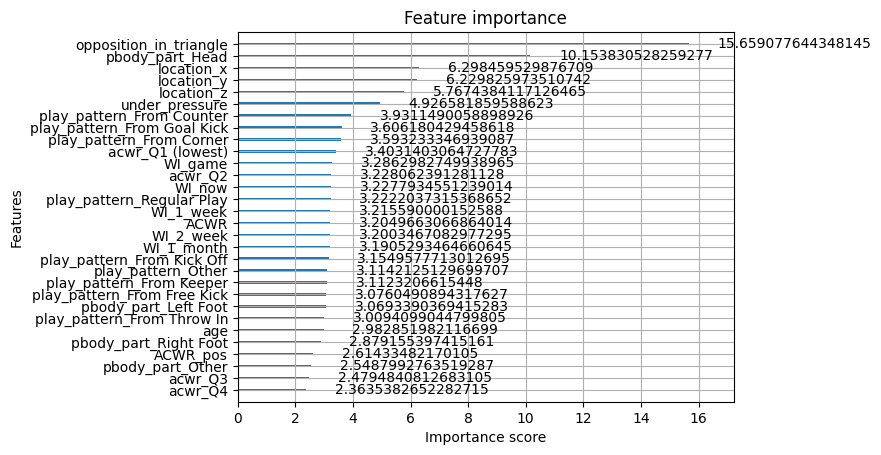

In [36]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()

In [37]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(30))

                             importance
opposition_in_triangle        15.659078
pbody_part_Head               10.153831
location_x                     6.298460
location_y                     6.229826
location_z                     5.767438
under_pressure                 4.926582
play_pattern_From Counter      3.931149
play_pattern_From Goal Kick    3.606180
play_pattern_From Corner       3.593233
acwr_Q1 (lowest)               3.403140
WI_game                        3.286298
acwr_Q2                        3.228062
WI_now                         3.227793
play_pattern_Regular Play      3.222204
WI_1_week                      3.215590
ACWR                           3.204966
WI_2_week                      3.200347
WI_1_month                     3.190529
play_pattern_From Kick Off     3.154958
play_pattern_Other             3.114213
play_pattern_From Keeper       3.112321
play_pattern_From Free Kick    3.076049
pbody_part_Left Foot           3.069339
play_pattern_From Throw In     3.009410


In [38]:
df.ACWR_bucket

0        Q1 (lowest)
1        Q1 (lowest)
2        Q1 (lowest)
3        Q1 (lowest)
4        Q1 (lowest)
            ...     
61649    Q1 (lowest)
61650             Q2
61651    Q1 (lowest)
61652             Q2
61653             Q3
Name: ACWR_bucket, Length: 60896, dtype: category
Categories (4, object): ['Q1 (lowest)' < 'Q2' < 'Q3' < 'Q4']

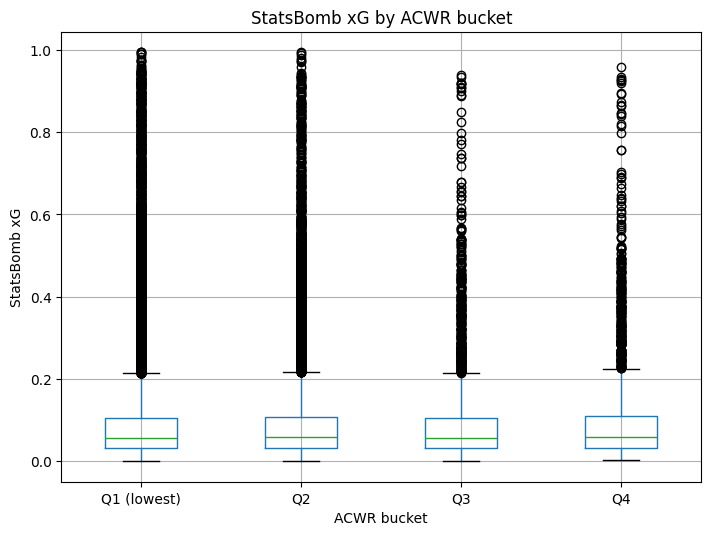

In [39]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

if not better explanation maybe different shots?

does match by match tiredness reduce shot number (quality) in next game? avg xg per shot?

match_date player avg_shot_xg (max ).str.endswith(('1_week', '2_week', '1_month')

In [40]:
shot_metrics_df.head(1)

,Unnamed: 0,event_id,event_index,period,timestamp,minute,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,location_x,location_y,location_z,related_events,player_id,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,gameId,match_date,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,birth_date,age,WI_now,WI_half,WI_game,WI_1_week,WI_2_week,WI_1_month,ACWR,ACWR_bucket,ACWR_pos
0,0,24392d1d-314a-4063-a729-7775bc0a2c45,130.0,1.0,00:03:04.524,3.0,4.0,9.0,0.471596,0.306241,0.278243,0.027997,0.007197,0.007197,0.0,0.027997,1,16.0,Shot,36.0,Manchester City,2.0,From Corner,36.0,Manchester City,112.7,39.9,0.22,"67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...",23616.0,Erling Håland,23.0,Center Forward,0.166126,1.0,0.0,Left Foot,1.0,3892755,2023-08-11,1.2,0.0,0.0,1.0,0.0,0.0,0.2,0.0,0.0,0.4,0.0,0.0,6.8,0.0,0.0,4.4,0.0,0.0,0.2,0.0,0.0,17.017352,0.0,0.0,15.196193,0.0,0.0,20.433466,0.0,0.0,5.187833,0.0,0.0,37.352316,0.0,0.0,1.821159,0.0,0.0,306.501986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000-07-21,23,342.357849,0.0,0.0,0.0,0.0,0.0,0.0,Q1 (lowest),0


In [41]:
pattern_cols = shot_metrics_df.filter(regex='_(1_week|2_week|1_month)$').columns
specific_cols = ["player_id", "match_date", "statsbomb_xg"]


In [42]:
shot_metrics_df[specific_cols + list(pattern_cols)]

,player_id,match_date,statsbomb_xg,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,WI_1_week,WI_2_week,WI_1_month
0,23616.0,2023-08-11,0.166126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3089.0,2023-08-11,0.023693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,23616.0,2023-08-11,0.142146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,256682.0,2023-08-11,0.083945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,48335.0,2023-08-11,0.085442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61649,33281.0,2025-05-21,0.052227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61650,3336.0,2025-05-21,0.032896,41.0,28.0,24.0,31.0,179.0,143.0,13.0,649.504211,452.373993,87.604786,31.513607,946.833862,197.130234,9112.357843,54.0,36.0,30.0,41.0,245.0,191.0,18.0,896.897354,612.508774,182.132470,62.765856,1304.603149,284.388603,13326.717089,109.0,80.0,64.0,77.0,461.0,376.0,29.0,1526.632279,1059.037552,358.421625,125.683497,2467.352782,467.594764,24987.345491,10608.496531,15404.900446,28508.204887
61651,151931.0,2025-05-21,0.024010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.0,17.0,12.0,15.0,99.0,76.0,3.0,196.334763,173.703934,99.947980,29.846633,615.028015,22.630829,5370.538105,98.0

In [69]:
shots_by_player_match = shot_metrics_df[specific_cols + list(pattern_cols)]#.groupby(["player_id","match_date"],as_index=False).min()

In [61]:
shots_by_player_match.columns

Index(['player_id', 'match_date', 'statsbomb_xg', 'Count HI_1_week',
       'Count HSR_1_week', 'Count High Acceleration_1_week',
       'Count High Deceleration_1_week', 'Count Medium Acceleration_1_week',
       'Count Medium Deceleration_1_week', 'Count Sprint_1_week',
       'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'M/min_1_week',
       'Max Speed_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week', 'Count HI_2_week',
       'Count HSR_2_week', 'Count High Acceleration_2_week',
       'Count High Deceleration_2_week', 'Count Medium Acceleration_2_week',
       'Count Medium Deceleration_2_week', 'Count Sprint_2_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'M/min_2_week',
       'Max Speed_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'Count HI_1_month', 'Count HSR_1_month',


In [70]:
group_col = ["player_id","match_date"]
mean_col = 'statsbomb_xg'

other_cols = [col for col in shots_by_player_match.columns if col not in group_col]

agg_dict = {mean_col: ['mean', 'sum', 'count']}
agg_dict.update({col: 'max' for col in other_cols if col != mean_col})

shots_by_player_match = shots_by_player_match.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
shots_by_player_match.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in shots_by_player_match.columns]



In [78]:
shots_by_player_match[shots_by_player_match["Count HSR_1_week_max"] > 300]

,player_id,match_date,statsbomb_xg_mean,statsbomb_xg_sum,statsbomb_xg_count,Count HI_1_week_max,Count HSR_1_week_max,Count High Acceleration_1_week_max,Count High Deceleration_1_week_max,Count Medium Acceleration_1_week_max,Count Medium Deceleration_1_week_max,Count Sprint_1_week_max,High Intensity (HI) Distance_1_week_max,High Speed Running (HSR) Distance_1_week_max,M/min_1_week_max,Max Speed_1_week_max,Running Distance_1_week_max,Sprinting Distance_1_week_max,Total Distance_1_week_max,Count HI_2_week_max,Count HSR_2_week_max,Count High Acceleration_2_week_max,Count High Deceleration_2_week_max,Count Medium Acceleration_2_week_max,Count Medium Deceleration_2_week_max,Count Sprint_2_week_max,High Intensity (HI) Distance_2_week_max,High Speed Running (HSR) Distance_2_week_max,M/min_2_week_max,Max Speed_2_week_max,Running Distance_2_week_max,Sprinting Distance_2_week_max,Total Distance_2_week_max,Count HI_1_month_max,Count HSR_1_month_max,Count High Acceleration_1_month_max,Count High Deceleration_1_month_max,Count Medium Acceleration_1_month_max,Count Medium Deceleration_1_month_max,Count Sprint_1_month_max,High Intensity (HI) Distance_1_month_max,High Speed Running (HSR) Distance_1_month_max,M/min_1_month_max,Max Speed_1_month_max,Running Distance_1_month_max,Sprinting Distance_1_month_max,Total Distance_1_month_max,WI_1_week_max,WI_2_week_max,WI_1_month_max
28907,106904.0,2023-10-21,0.177409,0.177409,1,594.044129,402.57536,314.205159,324.02407,1683.943275,1595.573074,191.468769,7918.213539,6185.942781,2929.206523,800.728955,12036.529442,1732.270670,85633.24073,1235.088258,839.150720,649.410318,675.048141,3499.886549,3321.146147,395.937538,16383.739517,12816.718661,5959.361693,1631.220530,24941.016892,3567.020663,178623.955358,1617.973769,1098.949166,852.399349,886.349329,4591.421512,4352.871695,519.024603,21481.575385,16800.951899,7943.286081,2167.154332,32715.067637,4680.623236,234119.374303,103201.938300,214958.454669,281763.147810
31072,199774.0,2024-10-19,0.067590,0.067590,1,1047.325579,598.47176,523.662790,523.66279,4862.583047,4937.392017,448.853820,18931.583524,14945.794222,18297.857385,4254.747523,35730.842018,3985.789003,245784.80098,2094.651159,1196.943519,1047.325579,1047.325579,9725.166094,9874.784034,897.707639,37863.167048,29891.588444,36595.714771,8509.495047,71461.684035,7971.578006,491569.601959,2094.651159,1196.943519,1047.325579,1047.325579,9725.166094,9874.784034,897.707639,37863.167048,29891.588444,36595.714771,8509.495047,71461.684035,7971.578006,491569.601959,287633.756433,575267.512865,575267.512865


In [80]:
shot_metrics_df[(shot_metrics_df.player_id==106904.0) |(shot_metrics_df.player_id==199774.0)].to_csv("what.csv")

    CHECK THIS OUT

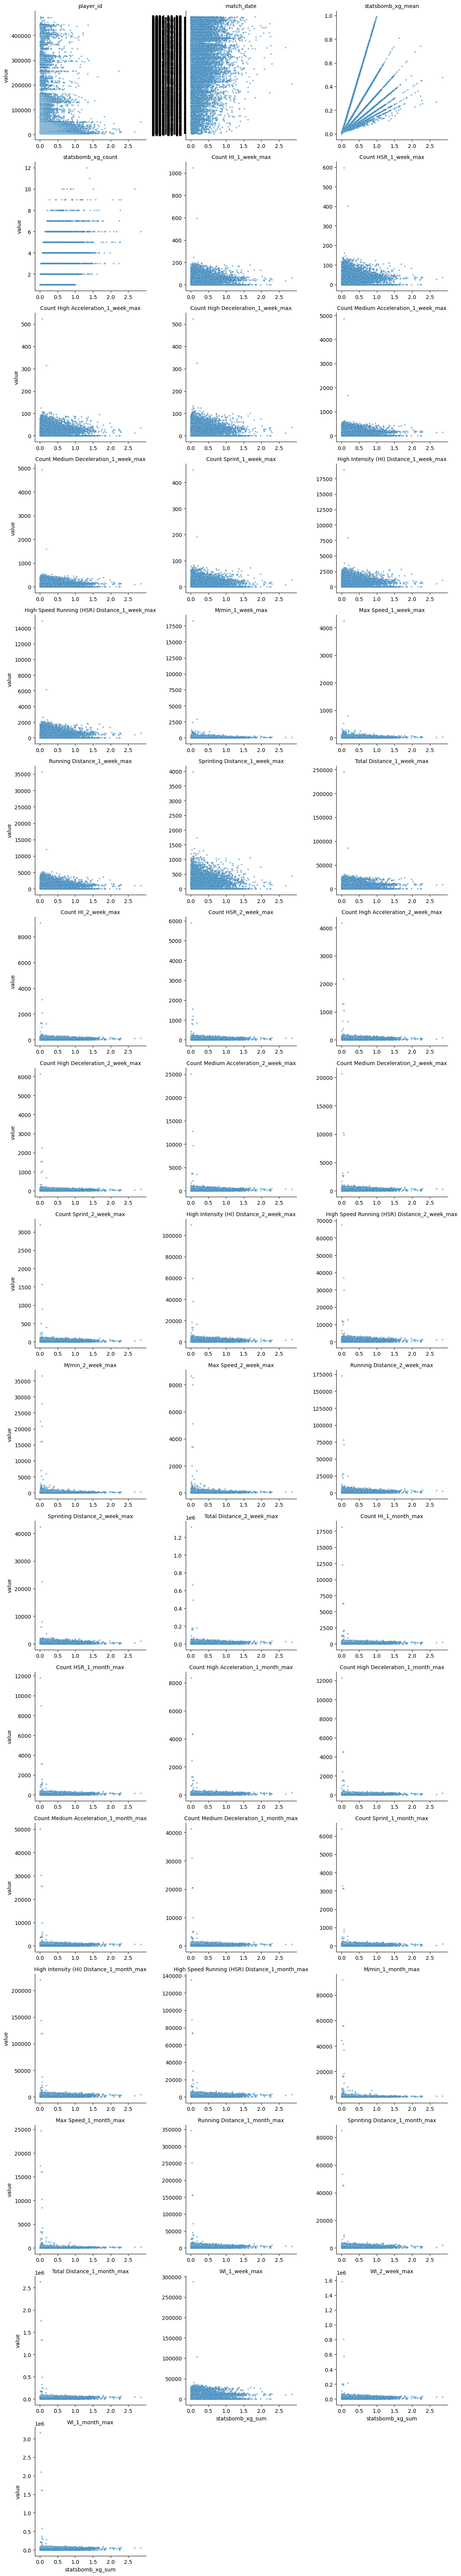

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "statsbomb_xg_sum"
df_melted = shots_by_player_match.melt(id_vars=target, var_name="variable", value_name="value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x=target, y="value", alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
plt.show()
